03 — Simulator Model (VoP & Fraud)

Goal: simulate how changing Verification of Payee (VoP) strictness and Fraud Filter threshold impacts the key KPIs:

Conversion Rate (%)

Latency p95 (seconds)

Manual Review Rate (%)

Risk Exposure (EUR)

This validates Hypothesis 2 (VoP vs Conversion/Latency) and Hypothesis 3 (Fraud Filter vs Risk/Reviews).

🧩 Stage 3 — Instant Payments Simulation Model (H2 & H3)
🎯 Goal

To simulate how operational settings — Verification of Payee (VoP) and Fraud Filter thresholds — affect the main Instant Payments KPIs:

✅ Conversion Rate (how many transactions pass all checks)

⏱ Latency p95 (how long the 95% fastest transactions take)

⚠️ Manual Review Rate (how many payments need human verification)

💶 Risk Exposure (EUR) (total value of undetected fraud)

We use synthetic data, because Bundesbank statistics do not include fraud or VoP fields.

In [5]:
import sys, os
sys.path.append(os.path.abspath(".."))

# Import standard libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import simulator core functions (your module)
from src.sim_core import generate_synth, simulate_vop, scan_vop, simulate_fraud, scan_fraud

# Make plots a bit larger and clearer
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

# Create a large synthetic dataset to get stable KPI curves
# We use 100_000 rows to reduce random noise in results
df = generate_synth(n=100_000, seed=42)

,transaction_id,amount_eur,fraud_probability,vop_match_score
0,1,3872.040682,0.938873,0.403694
1,2,2200.003414,0.947622,0.391789
2,3,4294.403620,0.536007,0.868009
3,4,3489.866465,0.250865,0.577615
4,5,479.944966,0.739323,0.759946


In [6]:
# Define grids of thresholds we want to scan
# VoP strictness: higher threshold => fewer transactions pass => lower conversion, higher latency
vop_thresholds = np.arange(0.50, 0.95, 0.05)

# Fraud threshold: lower threshold => more flags => more manual reviews, lower risk exposure
fraud_thresholds = np.arange(0.20, 0.90, 0.10)

(array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ]),
 array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))

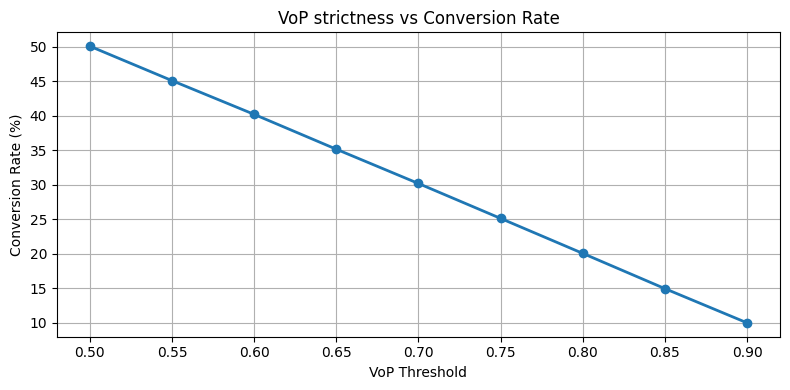

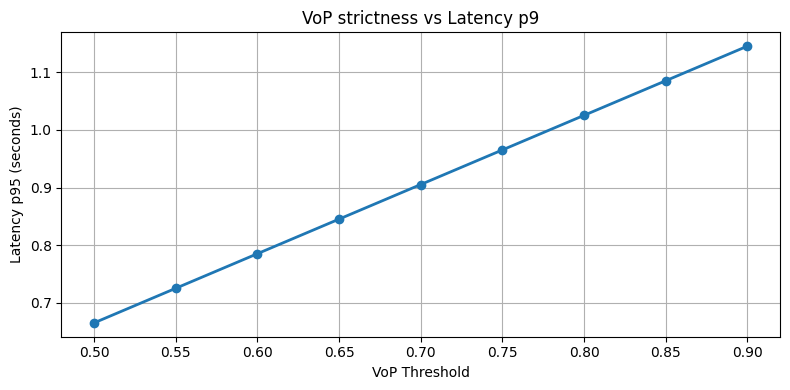

In [8]:
# Run VoP scans across the grid of thresholds
vop_results = scan_vop(df, vop_thresholds)

vop_results.head()

# Plot Conversion Rate vs VoP threshold
plt.figure()
plt.plot(vop_results["vop_threshold"], vop_results["conversion_rate"], marker="o", linewidth=2)
plt.title("VoP strictness vs Conversion Rate")
plt.xlabel("VoP Threshold")
plt.ylabel("Conversion Rate (%)")
plt.tight_layout()
plt.show()

# Plot Latency p95 vs VoP threshold
plt.figure()
plt.plot(vop_results["vop_threshold"], vop_results["latency_p95"], marker="o", linewidth=2)
plt.title("VoP strictness vs Latency p9")
plt.xlabel("VoP Threshold")
plt.ylabel("Latency p95 (seconds)")
plt.tight_layout()
plt.show()


H2 Finding:
As the VoP threshold increases, the Conversion Rate decreases while Latency p95 increases.

Interpretation:
Stricter payee verification reduces fraud and payment errors,
but introduces more manual reviews and extra validation steps.

Operational Impact:
This directly increases the load on the bank’s payment infrastructure and customer-service teams.
Higher latency and manual interventions mean the system must process more concurrent pending transactions,
raising pressure on both technical resources and operations staff.

Conclusion:
There is a clear trade-off — higher security vs lower throughput.
Finding the optimal VoP threshold (e.g., around 0.75–0.8) helps balance
fraud prevention and infrastructure efficiency.

🧩 H3 — Fraud Filter Simulation
🎯 Goal

To simulate how the fraud detection threshold affects two key KPIs:

Manual Review Rate (%): how many transactions are flagged for manual check.

Risk Exposure (EUR): how much money is potentially lost due to undetected fraud.

📘 Business meaning:
If the fraud filter is too strict — bank reviews too many transactions manually.
If too loose — the system may miss real frauds, increasing financial risk.

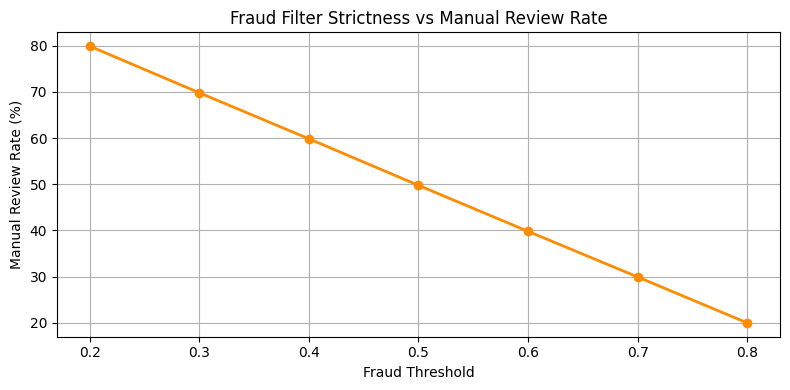

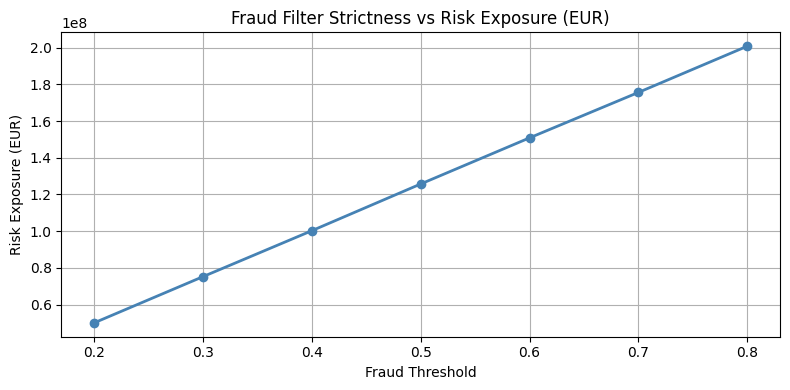

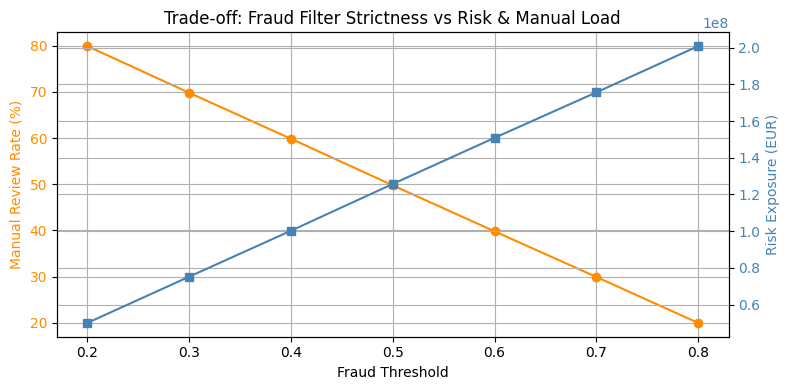

In [12]:
fraud_results = scan_fraud(df, fraud_thresholds)

fraud_results.head()

# Plot Manual Review Rate vs Fraud Threshold
plt.figure()
plt.plot(fraud_results["fraud_threshold"], fraud_results["manual_review_rate"], marker="o", linewidth=2, color="darkorange")
plt.title("Fraud Filter Strictness vs Manual Review Rate")
plt.xlabel("Fraud Threshold")
plt.ylabel("Manual Review Rate (%)")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(fraud_results["fraud_threshold"], fraud_results["risk_exposure_eur"], marker="o", linewidth=2, color="steelblue")
plt.title("Fraud Filter Strictness vs Risk Exposure (EUR)")
plt.xlabel("Fraud Threshold")
plt.ylabel("Risk Exposure (EUR)")
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots()

ax1.set_xlabel("Fraud Threshold")
ax1.set_ylabel("Manual Review Rate (%)", color="darkorange")
ax1.plot(fraud_results["fraud_threshold"], fraud_results["manual_review_rate"], color="darkorange", marker="o")
ax1.tick_params(axis="y", labelcolor="darkorange")

ax2 = ax1.twinx()
ax2.set_ylabel("Risk Exposure (EUR)", color="steelblue")
ax2.plot(fraud_results["fraud_threshold"], fraud_results["risk_exposure_eur"], color="steelblue", marker="s")
ax2.tick_params(axis="y", labelcolor="steelblue")

plt.title("Trade-off: Fraud Filter Strictness vs Risk & Manual Load")
fig.tight_layout()
plt.show()


H3 Finding:
As the fraud threshold increases, fewer transactions are flagged for manual review,
reducing operational load — but Risk Exposure (EUR) increases significantly.

Interpretation:
A lower threshold makes the fraud system more sensitive — it flags more transactions for review,
which decreases risk but burdens fraud analysts and slows down operations.

A higher threshold makes the filter more tolerant — faster processing,
but a higher chance of missing fraudulent payments.

Operational Impact:
The bank faces a trade-off between risk mitigation and operational efficiency.
Each extra percentage of flagged payments increases workload exponentially,
requiring more fraud investigators or automation.

Conclusion:
The optimal fraud threshold typically lies around 0.4–0.5,
where Risk Exposure is minimized while Manual Review Rate stays manageable.
This balance ensures both financial safety and sustainable team capacity.